# Sartorius - Cell Instance Segmentation: Baseline

The following Notebook is built as a project for the closed Kaggle competetion of the same name ([here](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview))

All data used can be found [here](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/data)

This Notebook is based on the following baseline: [Sartorius - Starter Torch Mask R-CNN](https://www.kaggle.com/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273)

### Imports

We begin, as all great notebooks do, with some imports.

In [1]:
# Standard Library Imports
import os
import time
import random
import collections

# Data Science Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# PyTorch Imports
import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor   #https://pytorch.org/vision/stable/models.html
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

Fix randomness:

In [2]:
def fix_all_seeds(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_all_seeds()

### Configuration

In [3]:
TRAIN_CSV_PATH = '../input/sartorius-cell-instance-segmentation/train.csv'

TRAIN_IMAGES_PATH = '../input/sartorius-cell-instance-segmentation/train/'
TEST_IMAGES_PATH = '../input/sartorius-cell-instance-segmentation/test/'

WIDTH = 704
HEIGHT = 520

#Reduce the Train Set
TEST = False

# Set Device
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  #cuda is GPU

# Declare ResNet Mean and Standard Deviation
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# Model Hyperparameters
BATCH_SIZE = 2
EPOCHS = 8

# Optimizer Hyperparameters
MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Use a StepLR Scheduler
USE_SCHEDULER = False

# Mask Confidence Threshold
MASK_THRESHOLD = 0.5

# Normalize to ResNet Mean and Standard Deviation
NORMALIZE = False

BOX_DETECTIONS_PER_IMG = 539
MIN_SCORE = 0.59

### Training Dataset

#### Utilities

##### Transformations

Provided from the baseline Notebook, as well as user "Abishek", these transformations are reworks of the baseline torch.transformation classes but acting on both the image and mask

In [4]:
class Compose:
    def __init__(self, transforms):           # First we init
        self.transforms = transforms    
    
    def __call__(self, image, target):
        for t in self.transforms:             #what's going on here?
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]        #From the second to last one to the end
            image = image.flip(-2)
            bbox = target['boxes']                  #here we create a bounding box
            bbox[:, [1,3]] = height - bbox[:, [3,1]]
            target['boxes'] = bbox
            target['masks'] = target['masks'].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target['boxes']
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target['masks'] = target['masks'].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, mean=RESNET_MEAN, std=RESNET_STD)   #this normalize function normalizes the image!
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data Augmentation
    if train:                                      #We only augment the train data
        transforms.append(HorizontalFlip(0.5))     #We use the Horizontal Flip functions
        transforms.append(VerticalFlip(0.5))       #We use the Vertical Flip - we created these functions just above
    return Compose(transforms)

Decoding [Run-Length Encoding](https://en.wikipedia.org/wiki/Run-length_encoding)

In [5]:
def rle_decode(mask_rle, shape, color=1):
    """
    params:
        mask_rle: run-lengthas string formatted (start length)
        shape:    (height, width) of array to return

    returns:
        numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = color
    return img.reshape(shape)

#### Training Dataset and DataLoader

In [6]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df

        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                'image_id'    : row['id'],
                'image_path'  : os.path.join(self.image_dir, row['id'] + '.png'),
                'annotations' : row['annotation']
            }
    
    def get_box(self, a_mask):
        '''Get the bounding box of a given mask'''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        '''Get the image and target'''

        img_path = self.image_info[idx]['image_path']
        img = Image.open(img_path).convert("RGB")

        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
            a_mask = Image.fromarray(a_mask)

            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask

            boxes.append(self.get_box(a_mask))

        # dummy labels
        labels = [1 for _ in range(n_objects)]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # Required Target for Mask R-CNN
        target = {
            'boxes'  : boxes,
            'labels' : labels,
            'masks'  : masks,
            'image_id' : image_id,
            'area'   : area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.image_info)

Finally, let's load that Data!

In [7]:
df_train = pd.read_csv(TRAIN_CSV_PATH, nrows=5000 if TEST else None)       #TRAIN_CSV_PATH variable created above
ds_train = CellDataset(TRAIN_IMAGES_PATH, df_train, resize=False, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

### Train Loop

#### Model

In [8]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/resnetmaskrcnn/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [9]:
def get_model():
    NUM_CLASSES = 2

    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img = BOX_DETECTIONS_PER_IMG,
                                                                   image_mean = RESNET_MEAN,
                                                                   image_std = RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img = BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)

    return model

# Get the Mask R-CNN model
# The model does classification + bounding boxes + masks, but we only care about masks
model = get_model()
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True

model.train();

#### Training Loop

In [10]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches = len(dl_train)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting Epoch: {epoch} / {EPOCHS}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    for batch_idx, (images, targets) in enumerate(dl_train, 1):

        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        if batch_idx % 50 == 0:
            print(f"[Batch {batch_idx:3d} / {n_batches:3d}] Loss: {loss.item():7.3f} Mask Loss: {loss_mask:7.3f}")

    if USE_SCHEDULER:
        lr_scheduler.step()

    # Train Losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches

    elapsed = time.time() - time_start

    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {EPOCHS:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

Starting Epoch: 1 / 8
[Batch  50 / 303] Loss:   1.819 Mask Loss:   0.403
[Batch 100 / 303] Loss:   1.186 Mask Loss:   0.291
[Batch 150 / 303] Loss:   1.597 Mask Loss:   0.297
[Batch 200 / 303] Loss:   1.177 Mask Loss:   0.272
[Batch 250 / 303] Loss:   1.637 Mask Loss:   0.354
[Batch 300 / 303] Loss:   1.425 Mask Loss:   0.310
[Epoch  1 /  8] Train mask-only loss:   0.355
[Epoch  1 /  8] Train loss:   1.715. [270 secs]
Starting Epoch: 2 / 8
[Batch  50 / 303] Loss:   1.342 Mask Loss:   0.311
[Batch 100 / 303] Loss:   1.869 Mask Loss:   0.314
[Batch 150 / 303] Loss:   2.074 Mask Loss:   0.454
[Batch 200 / 303] Loss:   1.233 Mask Loss:   0.276
[Batch 250 / 303] Loss:   1.594 Mask Loss:   0.312
[Batch 300 / 303] Loss:   1.389 Mask Loss:   0.321
[Epoch  2 /  8] Train mask-only loss:   0.320
[Epoch  2 /  8] Train loss:   1.500. [263 secs]
Starting Epoch: 3 / 8
[Batch  50 / 303] Loss:   1.309 Mask Loss:   0.340
[Batch 100 / 303] Loss:   1.431 Mask Loss:   0.294
[Batch 150 / 303] Loss:   1.534 

### Analyze Predictions

In [11]:
# Plots: the image, the image + the ground truth mask, the image + the predicted mask

def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.show()
    
    masks = np.zeros((HEIGHT, WIDTH))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Ground truth")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

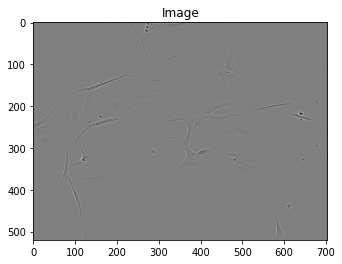

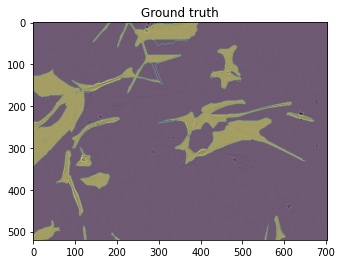

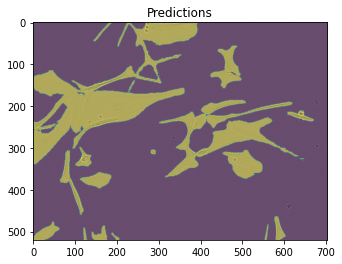

In [12]:
# NOTE: Puts the model in Eval Mode
analyze_train_sample(model, ds_train, 20)

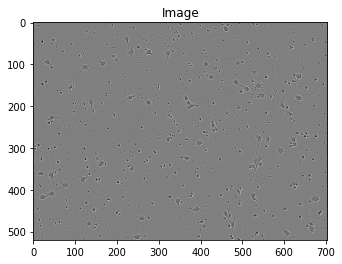

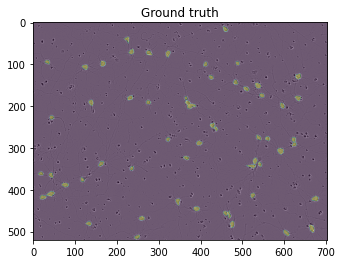

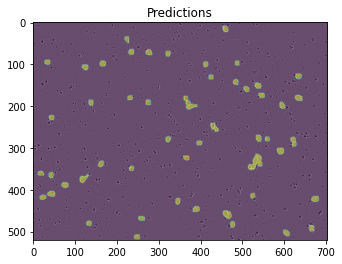

In [13]:
analyze_train_sample(model, ds_train, 100)

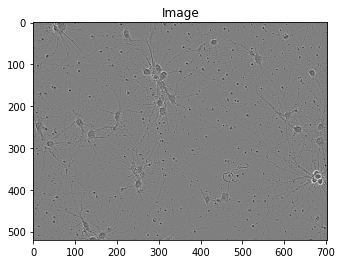

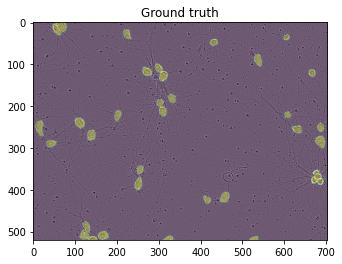

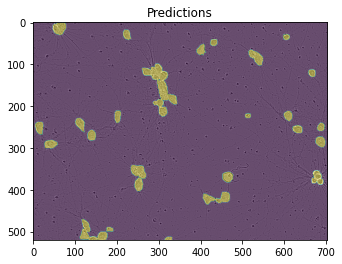

In [14]:
analyze_train_sample(model, ds_train, 2)

In [15]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

In [16]:
ds_test = CellTestDataset(TEST_IMAGES_PATH, transforms=get_transform(train=False))

In [17]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

In [18]:
model.eval();

submission = []
for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):
        
        # Filter-out low-scoring results. Not tried yet.
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:
            continue
        
        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
    
    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()

,id,predicted
0,7ae19de7bc2a,979 6 1682 9 2386 11 3091 13 3796 16 4501 17 5...
1,7ae19de7bc2a,139300 4 140002 19 140706 21 141410 21 142114 ...
2,7ae19de7bc2a,355815 9 356517 11 357220 13 357922 15 358626 ...
3,7ae19de7bc2a,183219 7 183923 8 184627 9 185331 10 186035 11...
4,7ae19de7bc2a,289240 13 289940 20 290644 21 291348 21 292052...
